In [1]:
# Importing the libraries 
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import shap

In [2]:
df = pd.read_csv("online_shoppers_intention.csv")

In [3]:
# Changing the boolean datatypes into integer datatypes
df['Weekend'] = df['Weekend'].astype('int64')
df['Revenue'] = df['Revenue'].astype('int64')

In [4]:
# Changing the other categorical variables into integer datatypes using ordinal encoding
# This transforms categorical value to numerical value in ordered sets through a dictionary

Month_dict = {'Feb' : 2, 'Mar': 3, 'May': 5, 'June': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

df['Month'] = df.Month.map(Month_dict)

VisitorType_dict = {'Other': 0, 'New_Visitor' : 1, 'Returning_Visitor': 2}

df['VisitorType'] = df.VisitorType.map(VisitorType_dict)

In [5]:
X = df.drop('Revenue', 1)
y = df['Revenue']

In [6]:
ab_model = AdaBoostClassifier()

In [7]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [8]:
ab_scores = cross_val_score(ab_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

In [9]:
print(np.mean(ab_scores))

0.8899702622330358


In [10]:
y_pred_ab = cross_val_predict(ab_model, X, y, cv=5)

In [11]:
matrix = confusion_matrix(y, y_pred_ab)
print(classification_report(y, y_pred_ab))
print("Cohen's Kappa:", cohen_kappa_score(y, y_pred_ab))
print("F1 score: ", f1_score(y, y_pred_ab))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93     10422
           1       0.60      0.51      0.55      1908

    accuracy                           0.87     12330
   macro avg       0.76      0.72      0.74     12330
weighted avg       0.86      0.87      0.87     12330

Cohen's Kappa: 0.4779129850145044
F1 score:  0.5519591141396933


AdaBoosts tends to predict class 0 rather than class 1, because of the imbalanced data.

In [12]:
# Use oversampling using SMOTE for the imbalanced dataset
columns = X.columns
os = SMOTE(random_state = 0)
os_data_X, os_data_y = os.fit_resample(X, y)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Revenue'])

In [13]:
X_os=os_data_X
y_os=os_data_y['Revenue']

In [14]:
ab_scores_os = cross_val_score(ab_model, X_os, y_os, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

In [15]:
print(np.mean(ab_scores_os))

0.9034415966981715


In [16]:
y_pred_ab_os = cross_val_predict(ab_model, X_os, y_os, cv=5)

In [17]:
matrix = confusion_matrix(y_os, y_pred_ab_os)
print(classification_report(y_os, y_pred_ab_os))
print("Cohen's Kappa:", cohen_kappa_score(y_os, y_pred_ab_os))
print("F1 score: ", f1_score(y_os, y_pred_ab_os))

              precision    recall  f1-score   support

           0       0.85      0.70      0.77     10422
           1       0.74      0.88      0.81     10422

    accuracy                           0.79     20844
   macro avg       0.80      0.79      0.79     20844
weighted avg       0.80      0.79      0.79     20844

Cohen's Kappa: 0.5761849932834389
F1 score:  0.805854687706035


The results show that the use of oversampling helps the AdaBoost model to predict the class 1 better. 

In [18]:
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in cv_outer.split(X_os):
    # split data
    X_train, X_test = X_os.iloc[train_ix, :], X_os.iloc[test_ix, :]
    y_train, y_test = y_os[train_ix], y_os[test_ix]
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
    # define the model
    model = AdaBoostClassifier(random_state = 1)
    # define search space
    space = dict()
    space['n_estimators'] = [10, 50, 100, 500]
    space['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
    # define search
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

>acc=0.912, est=0.908, cfg={'learning_rate': 1.0, 'n_estimators': 500}
>acc=0.911, est=0.908, cfg={'learning_rate': 1.0, 'n_estimators': 500}
>acc=0.901, est=0.910, cfg={'learning_rate': 1.0, 'n_estimators': 500}
>acc=0.914, est=0.906, cfg={'learning_rate': 1.0, 'n_estimators': 500}
>acc=0.910, est=0.908, cfg={'learning_rate': 1.0, 'n_estimators': 500}
Accuracy: 0.910 (0.005)


In [19]:
ab_model_cv = AdaBoostClassifier(learning_rate = 1.0, n_estimators = 500)
ab_scores_os_cv = cross_val_score(ab_model_cv, X_os, y_os, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print(np.mean(ab_scores_os_cv))

0.9093745352890289


In [20]:
y_pred_ab_os_cv = cross_val_predict(ab_model_cv, X_os, y_os, cv=5)

In [21]:
matrix = confusion_matrix(y_os, y_pred_ab_os_cv)
print(classification_report(y_os, y_pred_ab_os_cv))
print("Cohen's Kappa:", cohen_kappa_score(y_os, y_pred_ab_os_cv))
print("F1 score: ", f1_score(y_os, y_pred_ab_os_cv))

              precision    recall  f1-score   support

           0       0.85      0.70      0.77     10422
           1       0.75      0.88      0.81     10422

    accuracy                           0.79     20844
   macro avg       0.80      0.79      0.79     20844
weighted avg       0.80      0.79      0.79     20844

Cohen's Kappa: 0.5823258491652274
F1 score:  0.808026460859978


For fold 1:
Accuracy: 0.9255605381165919
f-score: 0.9225023342670402
Results on the test set:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2230
           1       0.96      0.89      0.92      2230

    accuracy                           0.93      4460
   macro avg       0.93      0.93      0.93      4460
weighted avg       0.93      0.93      0.93      4460



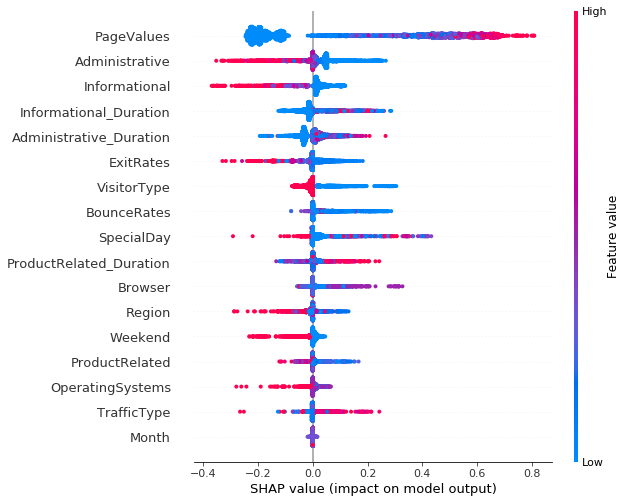

For fold 2:
Accuracy: 0.9473684210526315
f-score: 0.9477947794779479
Results on the test set:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2204
           1       0.94      0.96      0.95      2204

    accuracy                           0.95      4408
   macro avg       0.95      0.95      0.95      4408
weighted avg       0.95      0.95      0.95      4408



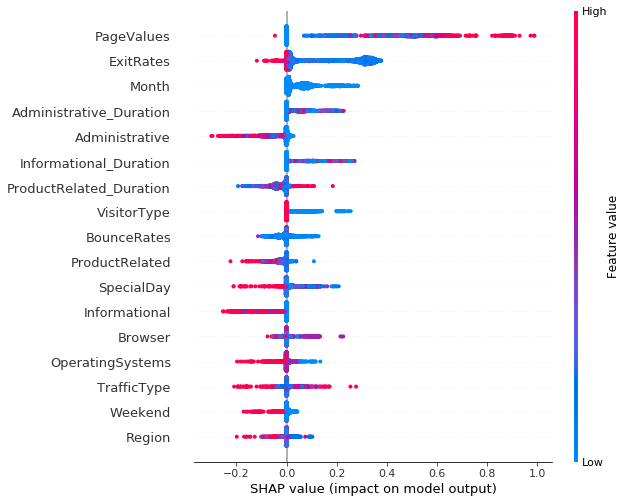

For fold 3:
Accuracy: 0.8873239436619719
f-score: 0.8926919518963922
Results on the test set:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      2059
           1       0.85      0.94      0.89      2059

    accuracy                           0.89      4118
   macro avg       0.89      0.89      0.89      4118
weighted avg       0.89      0.89      0.89      4118



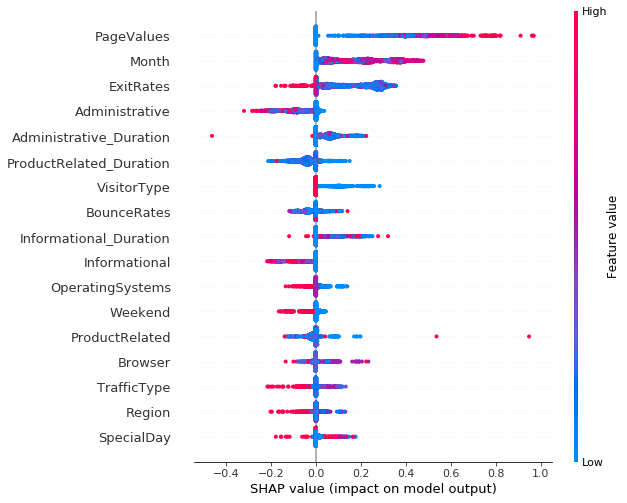

For fold 4:
Accuracy: 0.874552887072049
f-score: 0.8738113595476741
Results on the test set:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1957
           1       0.88      0.87      0.87      1957

    accuracy                           0.87      3914
   macro avg       0.87      0.87      0.87      3914
weighted avg       0.87      0.87      0.87      3914



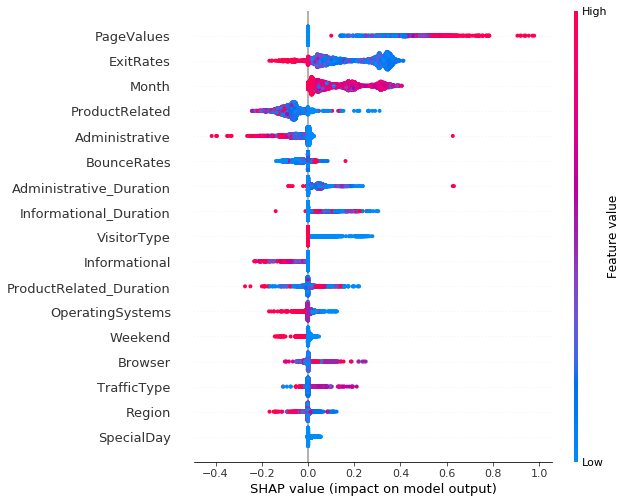

For fold 5:
Accuracy: 0.8701825557809331
f-score: 0.8658983761131483
Results on the test set:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1972
           1       0.90      0.84      0.87      1972

    accuracy                           0.87      3944
   macro avg       0.87      0.87      0.87      3944
weighted avg       0.87      0.87      0.87      3944



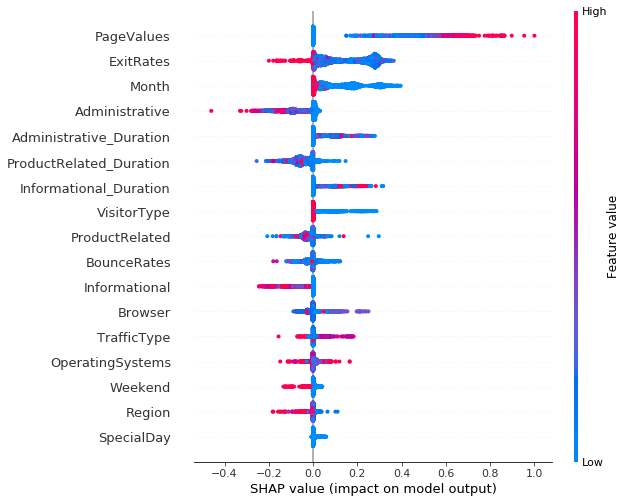

In [39]:
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

kf = KFold(n_splits=5)

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train = X.iloc[train_index, :]
    y_train = y[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
    X_test = X.iloc[test_index, :]
    y_test = y[test_index]  # See comment on ravel and  y_train
    X_train_oversampled, y_train_oversampled = os.fit_resample(X_train, y_train)
    X_test_oversampled, y_test_oversampled = os.fit_resample(X_test, y_test)
    model = AdaBoostClassifier(learning_rate = 1.0, n_estimators = 500)
    model.fit(X_train_oversampled, y_train_oversampled )  
    y_pred_oversampled = model.predict(X_test_oversampled)
    print(f'For fold {fold}:')
    print(f'Accuracy: {model.score(X_test_oversampled, y_test_oversampled)}')
    print(f'f-score: {f1_score(y_test_oversampled, y_pred_oversampled)}')
    print('Results on the test set:')
    print(classification_report(y_test_oversampled, y_pred_oversampled))
    explainer = shap.KernelExplainer(model.predict, X_train_oversampled[:10])
    shap_values_ab = explainer.shap_values(X_test_oversampled)
    shap.summary_plot(shap_values_ab, X_test_oversampled)
    #print(X_test_oversampled.mean())

The accuracy score for the second fold is the highest, indicating that PageValues, ExitRates, and Month are the most important features.

In [40]:
# Feature importance scores
shap_sum = (shap_values_ab).mean(axis=0)
importance_df = pd.DataFrame([X_os.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
8,PageValues,0.240477
7,ExitRates,0.141926
10,Month,0.112038
1,Administrative_Duration,0.0583905
3,Informational_Duration,0.0277283
15,VisitorType,0.0229807
14,TrafficType,0.00757835
9,SpecialDay,0.00548068
11,OperatingSystems,0.00436426
16,Weekend,0.000799301


In [41]:
# Feature importance scores
shap_sum = np.abs(shap_values_ab).mean(axis=0)
importance_df = pd.DataFrame([X_os.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
8,PageValues,0.240477
7,ExitRates,0.14579
10,Month,0.112038
0,Administrative,0.0594028
1,Administrative_Duration,0.0583905
5,ProductRelated_Duration,0.0508312
3,Informational_Duration,0.0277283
15,VisitorType,0.0229807
4,ProductRelated,0.02208
6,BounceRates,0.0215326


Gradient Boosting

In [22]:
X = df.drop('Revenue', 1)
y = df['Revenue']

In [23]:
gb_model = GradientBoostingClassifier()

In [24]:
gb_scores = cross_val_score(gb_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

In [25]:
print(np.mean(gb_scores))

0.9029467423628006


In [26]:
y_pred_gb = cross_val_predict(gb_model, X, y, cv=5)

In [27]:
matrix = confusion_matrix(y, y_pred_gb)
print(classification_report(y, y_pred_gb))
print("Cohen's Kappa:", cohen_kappa_score(y, y_pred_gb))
print("F1 score: ", f1_score(y, y_pred_gb))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94     10422
           1       0.69      0.58      0.63      1908

    accuracy                           0.89     12330
   macro avg       0.81      0.76      0.78     12330
weighted avg       0.89      0.89      0.89     12330

Cohen's Kappa: 0.5670868760313557
F1 score:  0.6279668287103232


Gradient Boosting tends to predict class 0 rather than class 1, because of the imbalanced data.

In [28]:
# Use oversampling using SMOTE for the imbalanced dataset
columns = X.columns
os = SMOTE(random_state = 0)
os_data_X, os_data_y = os.fit_resample(X, y)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Revenue'])

In [29]:
X_os=os_data_X
y_os=os_data_y['Revenue']

In [30]:
gb_scores_os = cross_val_score(gb_model, X_os, y_os, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

In [31]:
print(np.mean(gb_scores_os))

0.9149877105289368


In [32]:
y_pred_gb_os = cross_val_predict(gb_model, X_os, y_os, cv=5)

In [33]:
matrix = confusion_matrix(y_os, y_pred_gb_os)
print(classification_report(y_os, y_pred_gb_os))
print("Cohen's Kappa:", cohen_kappa_score(y_os, y_pred_gb_os))
print("F1 score: ", f1_score(y_os, y_pred_gb_os))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89     10422
           1       0.88      0.91      0.89     10422

    accuracy                           0.89     20844
   macro avg       0.89      0.89      0.89     20844
weighted avg       0.89      0.89      0.89     20844

Cohen's Kappa: 0.782767223181731
F1 score:  0.893036001133894


The results show that the use of oversampling helps Gradient Boosting model to predict the class 1 better. 

In [34]:
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
for train_ix, test_ix in cv_outer.split(X_os):
    # split data
    X_train, X_test = X_os.iloc[train_ix, :], X_os.iloc[test_ix, :]
    y_train, y_test = y_os[train_ix], y_os[test_ix]
    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
    # define the model
    model = GradientBoostingClassifier(random_state = 1)
    # define search space
    space = dict()
    space['n_estimators'] = [10, 50, 100, 500]
    space['learning_rate'] = [1, 0.1, 0.01, 0.001]
    space['subsample'] = [0.5,0.7,1]
    space['max_depth'] = [3,7,9]
    # define search
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    # execute search
    result = search.fit(X_train, y_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

>acc=0.937, est=0.935, cfg={'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.7}
>acc=0.941, est=0.936, cfg={'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.7}
>acc=0.934, est=0.936, cfg={'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.5}
>acc=0.939, est=0.935, cfg={'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.7}
>acc=0.935, est=0.937, cfg={'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 500, 'subsample': 0.7}
Accuracy: 0.937 (0.002)


In [35]:
gb_model_cv = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 9, n_estimators = 500, subsample = 0.7)
gb_scores_os_cv = cross_val_score(gb_model_cv, X_os, y_os, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print(np.mean(gb_scores_os_cv))

0.9388473702327464


In [36]:
y_pred_gb_os_cv = cross_val_predict(gb_model_cv, X_os, y_os, cv=5)

In [37]:
matrix = confusion_matrix(y_os, y_pred_gb_os_cv)
print(classification_report(y_os, y_pred_gb_os_cv))
print("Cohen's Kappa:", cohen_kappa_score(y_os, y_pred_gb_os_cv))
print("F1 score: ", f1_score(y_os, y_pred_gb_os_cv))

              precision    recall  f1-score   support

           0       0.94      0.89      0.91     10422
           1       0.90      0.94      0.92     10422

    accuracy                           0.91     20844
   macro avg       0.92      0.91      0.91     20844
weighted avg       0.92      0.91      0.91     20844

Cohen's Kappa: 0.8293033966609096
F1 score:  0.9167095837820123


For fold 1:
Accuracy: 0.9085201793721973
f-score: 0.90290337934317
Results on the test set:
              precision    recall  f1-score   support

           0       0.87      0.97      0.91      2230
           1       0.96      0.85      0.90      2230

    accuracy                           0.91      4460
   macro avg       0.91      0.91      0.91      4460
weighted avg       0.91      0.91      0.91      4460



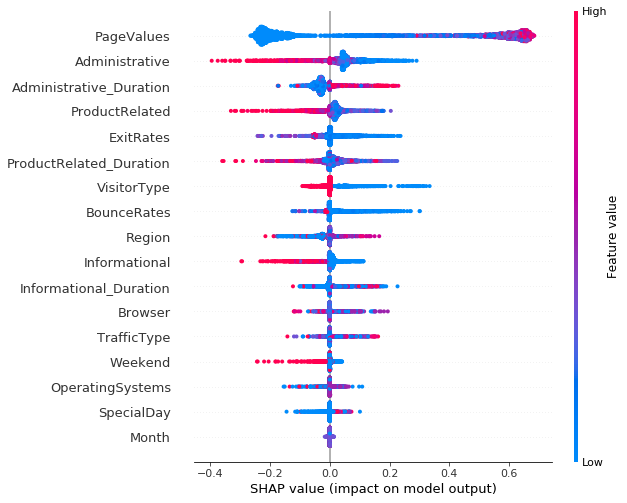

For fold 2:
Accuracy: 0.9505444646098004
f-score: 0.9513826940231935
Results on the test set:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      2204
           1       0.94      0.97      0.95      2204

    accuracy                           0.95      4408
   macro avg       0.95      0.95      0.95      4408
weighted avg       0.95      0.95      0.95      4408



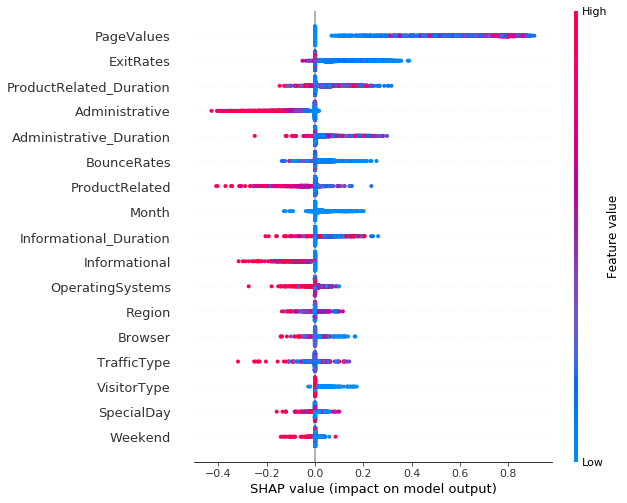

For fold 3:
Accuracy: 0.8861097620203983
f-score: 0.8873949579831933
Results on the test set:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      2059
           1       0.88      0.90      0.89      2059

    accuracy                           0.89      4118
   macro avg       0.89      0.89      0.89      4118
weighted avg       0.89      0.89      0.89      4118



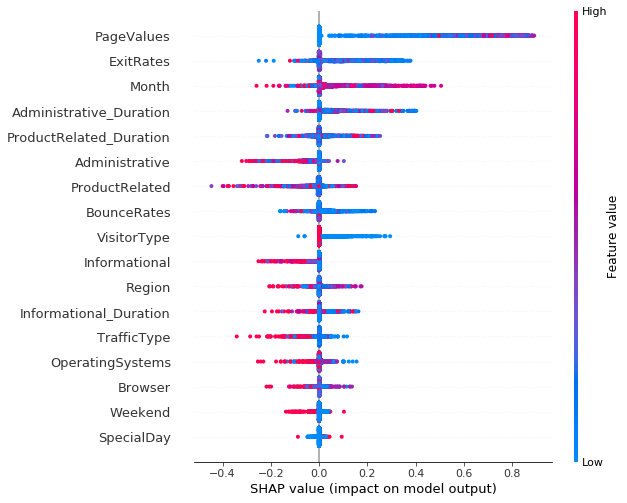

For fold 4:
Accuracy: 0.8719979560551865
f-score: 0.8657915885346905
Results on the test set:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1957
           1       0.91      0.83      0.87      1957

    accuracy                           0.87      3914
   macro avg       0.88      0.87      0.87      3914
weighted avg       0.88      0.87      0.87      3914



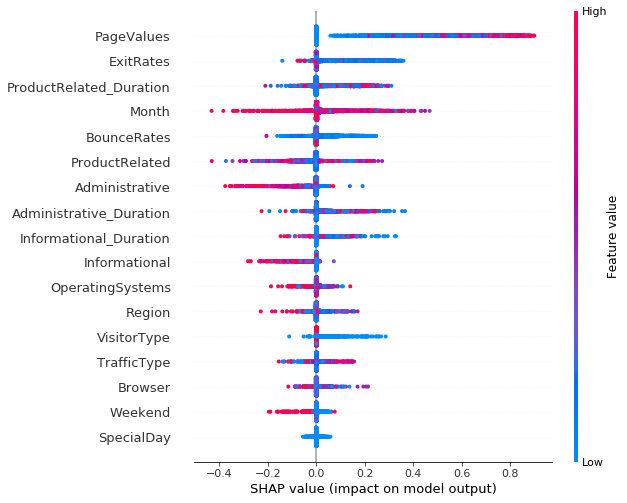

For fold 5:
Accuracy: 0.8580121703853956
f-score: 0.8469108802624384
Results on the test set:
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1972
           1       0.92      0.79      0.85      1972

    accuracy                           0.86      3944
   macro avg       0.87      0.86      0.86      3944
weighted avg       0.87      0.86      0.86      3944



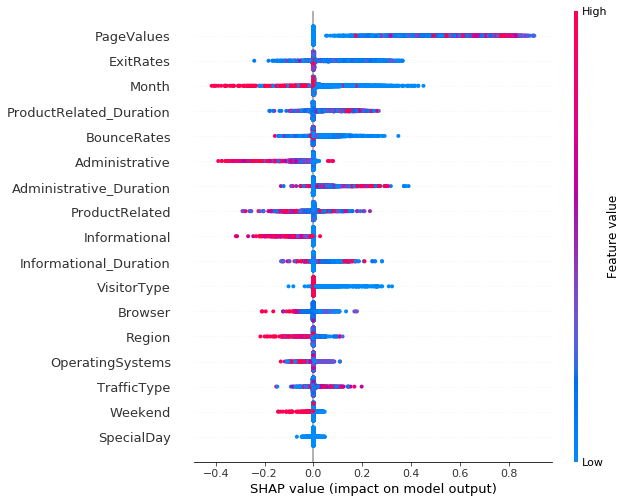

In [45]:
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

kf = KFold(n_splits=5)

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train = X.iloc[train_index, :]
    y_train = y[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
    X_test = X.iloc[test_index, :]
    y_test = y[test_index]  # See comment on ravel and  y_train
    X_train_oversampled, y_train_oversampled = os.fit_resample(X_train, y_train)
    X_test_oversampled, y_test_oversampled = os.fit_resample(X_test, y_test)
    model = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 9, n_estimators = 500, subsample = 0.7)
    model.fit(X_train_oversampled, y_train_oversampled )  
    y_pred_oversampled = model.predict(X_test_oversampled)
    print(f'For fold {fold}:')
    print(f'Accuracy: {model.score(X_test_oversampled, y_test_oversampled)}')
    print(f'f-score: {f1_score(y_test_oversampled, y_pred_oversampled)}')
    print('Results on the test set:')
    print(classification_report(y_test_oversampled, y_pred_oversampled))
    #explainer = shap.TreeExplainer(model)
    explainer = shap.KernelExplainer(model.predict, X_train_oversampled[:10]) 
    shap_values_gb = explainer.shap_values(X_test_oversampled)
    shap.summary_plot(shap_values_gb, X_test_oversampled)
    #print(X_test_oversampled.mean())

The accuracy score for the second fold is the highest, indicating that PageValues, ExitRates, and ProductRelated_Duration are the most important features.

In [46]:
# Feature importance scores
shap_sum = (shap_values_gb).mean(axis=0)
importance_df = pd.DataFrame([X_os.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
8,PageValues,0.257049
7,ExitRates,0.0614699
5,ProductRelated_Duration,0.0411745
10,Month,0.0402982
6,BounceRates,0.0381731
1,Administrative_Duration,0.0301335
15,VisitorType,0.00972159
3,Informational_Duration,0.00946756
11,OperatingSystems,0.00368655
14,TrafficType,0.00359484


In [47]:
# Feature importance scores
shap_sum = np.abs(shap_values_gb).mean(axis=0)
importance_df = pd.DataFrame([X_os.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
8,PageValues,0.257049
7,ExitRates,0.0667733
10,Month,0.0553785
5,ProductRelated_Duration,0.0468361
6,BounceRates,0.0414969
0,Administrative,0.0404183
1,Administrative_Duration,0.0308833
4,ProductRelated,0.0251903
2,Informational,0.0140875
3,Informational_Duration,0.0109332
